# Underlying Distribution Charts for Presentation Script

## Entrance criteria:
The intermediate dataset for Patients has been created and includes:<br>
1. removal of rows with bad provider info (null for start date)
2. removal of duplicate rows
3. addition of encoded columns for categorical values
4. merging of duplicate rows based on multi-entry of crew member roles

__Description:__<br>
__This is not an analytics script.  It is used to generate final graphics for presentation only.__
This script generates the graphics used in the final presentation for the underlying distributions chart.  It reads in the patients data set to use in the generation of:<br>
1. the tenure split violin plot
2. the gender nested donut plot
3. the patient outcome distribution bar plot

<br>It also generates the medications and procedures plot but does not calculate the numbers in this script.  It merely generates the plots base on the numbers generated in the respective analysis scripts:
1. 20210410-eem-daen690-Q2a.ipynb (for procedure information)
2. 20210408-au-medication-tenure-relation.ipynb (for medication information)

__Author:__ Michael McRae
***

## Initialization of the script, loading libraries, etc.

In [100]:
import numpy as np
import pandas as pd
import datetime as dt

# Used for visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# Setup HTML display
from IPython.core.display import display, HTML
# Notebook cell width adjustment
display(HTML('<style>.container { width:80% !important; }</style>'))

## Set font sizes
FONT_SMALL = 10
FONT_MEDIUM = 15
FONT_LARGE = 22
plt.rcParams.update({'font.size': FONT_SMALL})

## Read in the data file

In [101]:
df_patients = pd.read_csv(r'../data/02_intermediate/dfPatients_dedup.csv')
df_patients.shape

(543258, 22)

***
***
## Need to Remove records that have nulls in the Patient Outcome Column for this question


In [102]:
df_patients[df_patients.PatientOutcome.isnull()]

,Unnamed: 0,PatientId,FRDPersonnelID,Shift,UnitId,FireStation,Battalion,PatientOutcome,PatientGender,DispatchTime,...,CrewMemberRoles,TenureMonths,ShiftCode,Shift_A,Shift_B,Shift_C,UnitIdCode,PatientOutcomeCode,PatientGenderCode,ProviderGenderCode
184196,184210,805279,CBDB5C16-ED8B-4326-8301-12A84F6542F0,C - Shift,M432,32,407,NaN,NaN,2018-12-03 15:44:23,...,"Primary Patient Caregiver-At Scene,Primary Pat...",19,3,0,0,1,50,0,0,1
184197,184211,805279,98D6C99E-9E01-E211-B5F5-78E7D18CFD3C,C - Shift,M432,32,407,NaN,NaN,2018-12-03 15:44:23,...,"Driver-Response,Driver-Transport",330,3,0,0,1,50,0,0,2


In [103]:
df_patient2=df_patients.dropna(axis=0,subset=['PatientOutcome'])
print("df_patient  -> {}\ndf_patient2 -> {}".format(len(df_patients),len(df_patient2)))

df_patient  -> 543258
df_patient2 -> 543256


In [104]:
df_patients=df_patient2

## Looks Like simple correlations are not going to be very useful so lets look at some other ways to investigate relationships
***
## But first we need to check out the tenure of the providers so we have a better understanding of what we are working with.

## Convert the date fields that were read in as strings into datetime objects

In [105]:

df_patients["DispatchTime"]=df_patients["DispatchTime"].astype('datetime64[ns]')
df_patients["FRDPersonnelStartDate"]=df_patients["FRDPersonnelStartDate"].astype('datetime64[ns]')


## Find the time travelers (those with start dates after the dispatch date)

In [106]:
#Extract the records with a time traveler for a provider and put them in a new dataset
df_TimeTravelers=df_patients[(df_patients["DispatchTime"].dt.date - df_patients["FRDPersonnelStartDate"].dt.date)<dt.timedelta()]
df_TimeTravelers.shape

(573, 22)

In [107]:
# Create a dataframe with just the FRD Personnel Information (ID,StartDate), and Dispatch Time
df_tt=df_TimeTravelers
df_ttID=df_tt["FRDPersonnelID"].unique()
df_ttID=pd.DataFrame({"FRDPersonnelID" : df_ttID})
df_ttDetail=pd.merge(df_ttID,df_tt[["FRDPersonnelID","DispatchTime","FRDPersonnelStartDate"]],
                    how='outer', on='FRDPersonnelID')
            


In [108]:
#Find the providers that are the time travelers (unique IDs)  This is for our Partner to Vet
pd.merge(df_ttID,df_tt[["FRDPersonnelID","FRDPersonnelStartDate"]],
                    how='left', on='FRDPersonnelID').drop_duplicates()


,FRDPersonnelID,FRDPersonnelStartDate
0,DDB27180-A778-4655-8FC6-F9511F36175B,2020-04-13
97,A7D3C99E-9E01-E211-B5F5-78E7D18CFD3C,2018-01-08
99,86D2C99E-9E01-E211-B5F5-78E7D18CFD3C,2019-10-29
447,3FD2C99E-9E01-E211-B5F5-78E7D18CFD3C,2019-01-21
462,6FB584B8-F37D-45E3-8FCC-C820ACF46816,2019-12-09
500,40749ECE-1493-4759-B3E2-643F8D2A71EA,2020-10-26
551,380F3265-F26A-4EF1-A1AD-5D8A9E41D12A,2020-08-06


## Remove the Time travelers
The determiniation was to remove the time travelers from the dataset as there were only 7 providers that accounted for 573 records.

In [109]:
df_patientsGood = df_patients[(df_patients["DispatchTime"].dt.date - df_patients["FRDPersonnelStartDate"].dt.date)>=dt.timedelta()]
df_patientsGood.shape

(542683, 22)

***

In [110]:
#Put the value_counts into a dataframe  
value_counts=df_patientsGood['PatientOutcome'].value_counts()
df_Outcomes=pd.DataFrame(value_counts)
df_Outcomes.reset_index(inplace=True)
df_Outcomes.columns=["Outcome","Count"]
df_Outcomes.set_index(keys=["Outcome"])
df_Outcomes

,Outcome,Count
0,Treated & Transported,355825
1,Patient Refusal (AMA),46554
2,No Treatment/Transport Required,44836
3,Canceled (Prior to Arrival),38644
4,EMS Assist (Other Agency),13655
5,"Canceled (On Scene, No Patient Contact)",12176
6,No Patient Found,10490
7,Standby (No Services Performed),8647
8,Patient Dead at Scene (No EMS CPR),4853
9,Standby (Operational Support Provided),3235


In [111]:
#Create the OutcomeOrder array from the newly created dataframe
OutcomeOrder=np.array(df_Outcomes["Outcome"])
OutcomeOrder

array(['Treated & Transported ', 'Patient Refusal  (AMA)',
       'No Treatment/Transport Required', 'Canceled (Prior to Arrival) ',
       'EMS Assist (Other Agency)',
       'Canceled (On Scene, No Patient Contact) ', 'No Patient Found',
       'Standby (No Services Performed)',
       'Patient Dead at Scene (No EMS CPR)',
       'Standby (Operational Support Provided)',
       'Treated, Transferred Care ',
       'Patient Dead at Scene (EMS CPR Attempted)'], dtype=object)

***
## Let's get some record counts and some potentially useful dataframes of unique values (provider, CrewMemberRoles)

### First the Providers

In [129]:
Providers=df_patientsGood["FRDPersonnelID"].value_counts()
df_Providers=pd.DataFrame(Providers)
df_Providers.reset_index(inplace=True)
df_Providers.columns=["ProviderID","Count"]
df_Providers.set_index(keys=["ProviderID"])
df_Providers2=pd.merge(df_Providers,df_patientsGood[["FRDPersonnelID","FRDPersonnelGender", "TenureYears"]],how="left", left_on="ProviderID", right_on="FRDPersonnelID")


### Then the Patients

In [208]:
Patients=df_patientsGood["PatientId"].value_counts()
df_Patients=pd.DataFrame(Patients)
df_Patients.reset_index(inplace=True)
df_Patients.columns=["PatientId","Count"]
df_Patients.set_index(keys=["PatientId"])
df_Patients2=pd.merge(df_Patients,df_patientsGood[["PatientId","PatientGender"]],how='left', on="PatientId")

### Then the Crew Member Roles

In [114]:
CMRoles=df_patientsGood['CrewMemberRoles'].value_counts()
df_Roles=pd.DataFrame(CMRoles)
df_Roles.reset_index(inplace=True)
df_Roles.columns=["CrewMemberRoles","Count"]
df_Roles.set_index(keys=["CrewMemberRoles"])
df_Roles

,CrewMemberRoles,Count
0,"Primary Patient Caregiver-At Scene,Primary Pat...",210651
1,"Driver-Response,Driver-Transport",97309
2,"Driver-Response,Driver-Transport,Other Patient...",82208
3,"Primary Patient Caregiver-Transport,Primary Pa...",25831
4,"Driver-Transport,Driver-Response",25817
...,...,...
217,"Primary Patient Caregiver-Transport,Primary Pa...",1
218,"Primary Patient Caregiver-At Scene,Driver-Resp...",1
219,"Intern/Student,Primary Patient Caregiver-Trans...",1
220,"Primary Patient Caregiver-At Scene,Primary Pat...",1


### Now lets get some useful counts and put them in a dataframe for future reference

In [115]:
num_uProviders =len(df_patientsGood["FRDPersonnelID"].unique())
num_uPatients  =len(df_patientsGood["PatientId"].unique()) 
num_uCrewMemberRoles =len(df_patientsGood["CrewMemberRoles"].unique())
num_DriverRecords=len(df_patientsGood[df_patientsGood['CrewMemberRoles'].str.find('Driver')!=(-1)])
num_PrimaryCareRecords =len(df_patientsGood[df_patientsGood['CrewMemberRoles'].str.find('Primary')!=(-1)])
num_TotalRecords=len(df_patientsGood)
df_Counts=pd.DataFrame({"Name" : ["Providers", "Patients", "CrewMemberRoles", "DriverRecords", "PrimaryCareRecords","TotalRecords"],
                        "Value" : [num_uProviders, num_uPatients, num_uCrewMemberRoles, num_DriverRecords, num_PrimaryCareRecords, num_TotalRecords]})
df_Counts

,Name,Value
0,Providers,1828
1,Patients,246928
2,CrewMemberRoles,222
3,DriverRecords,247677
4,PrimaryCareRecords,246920
5,TotalRecords,542683


### Now lets bin by years.  Here we simply divide the TenureMonths by 12 and drop the remainder.
__Calculation of Tenure in Months results in value that represents number of completed years of service.  (e.g. 35 months -> 2 years, 36 months -> 3 years)__

In [116]:
df_patientsGood.loc[:,"TenureYears"]=np.floor(df_patientsGood["TenureMonths"]/12).astype(int)

C:\Users\Michael\Anaconda3_7\envs\emspe\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Michael\Anaconda3_7\envs\emspe\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [149]:
df_ProvidersGrp=df_Providers2.groupby(by=["TenureYears","FRDPersonnelGender"])
dfx=pd.DataFrame(df_ProvidersGrp.size())
dfx.reset_index(inplace=True)
dfx.columns=["TenureYears","ProviderGender","Count"]
dfx

,TenureYears,ProviderGender,Count
0,0,Female,1325
1,0,Male,5641
2,1,Female,7014
3,1,Male,36531
4,2,Female,8348
...,...,...,...
68,37,Male,11
69,38,Male,10
70,46,Male,10
71,47,Male,1


In [204]:
df_Providers2["FRDPersonnelGender"].value_counts()

Male      455588
Female     87095
Name: FRDPersonnelGender, dtype: int64

### Exploration into the distributions for tenure of the providers.

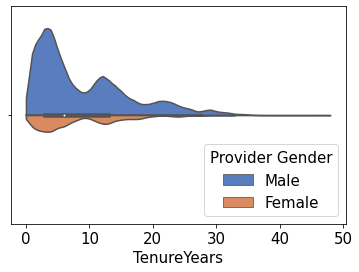

In [258]:
fig,ax=plt.subplots()
plt.rcParams.update({'font.size': FONT_MEDIUM})
ax=sns.violinplot(x="TenureYears", y=[""]*len(df_patientsGood), hue="FRDPersonnelGender",
               data=df_patientsGood,
               split=True,
               palette="muted",
               scale='count', 
               cut=0, 
#               inner='quartile'
              );
fig.get_axes()[0].legend(title= 'Provider Gender',loc='lower right')
plt.savefig('Tenure.png',bbox_inches='tight',pad_inches=.1, transparent=False)
plt.show()


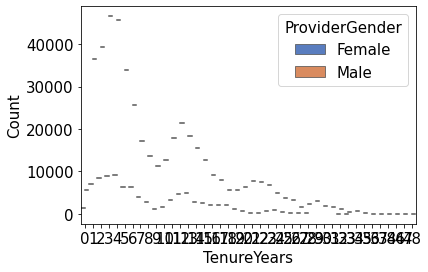

In [153]:

plt.rcParams.update({'font.size': FONT_MEDIUM})
sns.violinplot(x="TenureYears", y="Count", hue="ProviderGender",
               data=dfx,
               split=True,
               palette="muted",
               scale='area', cut=0);

In [210]:
df_Patients2["PatientGender"].value_counts()

Female                           210138
Male                             201244
Unknown (Unable to Determine)       176
Name: PatientGender, dtype: int64

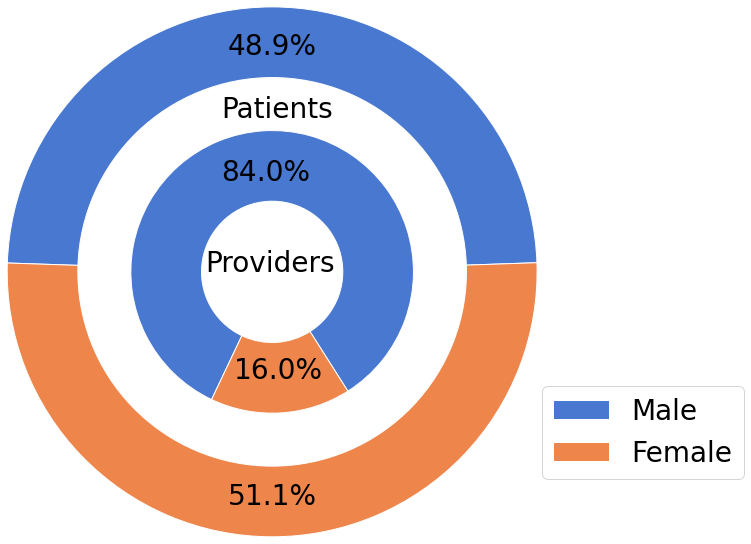

In [251]:


plt.rcParams.update({'font.size': 28})
# build the labels and counts to display
source_labels = ["Male","Female"]
source_counts = [201244,210138]

source_counts2= [455588,87095]
fig,ax=plt.subplots(figsize=(8,8))
fig.tight_layout()
fig.subplots_adjust(top=1.85)
fig.subplots_adjust(top=0.92)
#fig.suptitle("Procedures Performed", fontsize=FONT_LARGE)


cmap = plt.get_cmap("tab20c")
c2map = sns.color_palette("muted")

outer_colors = cmap([1,5])
inner_colors = cmap([2,6])

outer_colors = c2map[0:2]
inner_colors = outer_colors

w,t,at= ax.pie(x=source_counts,
#               labels=source_labels,
               autopct='%1.1f%%',
#               labeldistance=1.1, 
               radius=1.5, 
               colors=outer_colors, 
               pctdistance=.85,
               startangle=1.98,
      wedgeprops=dict(width=.4,edgecolor='w'))
ax.pie(x=source_counts2,
       autopct='%1.1f%%',
       labeldistance=1.1, 
       radius=.8,
       colors=inner_colors, 
       startangle=-57.6,
       pctdistance=.7,
      wedgeprops=dict(width=.4,edgecolor='w'))
ax.text(.348,.5,'Providers',transform=ax.transAxes)
ax.text(.385,.85,'Patients',transform=ax.transAxes)
#ax.text(.41,.13,'Patients',transform=ax.transAxes)
ax.legend(w,["Male","Female"],loc="lower right", bbox_to_anchor=(1.1,0,0.5,1))
#ircle2=plt.Circle( (0,0), 0.80, color='white')
#circle2=ax.pie(x=source_counts,labels=source_labels,autopct='%1.1f%%',labeldistance=1.1)
#p=plt.gcf()
#p.gca().add_artist(circle2)
plt.savefig('PIE_Gender.png',bbox_inches='tight',pad_inches=.1, transparent=False)
plt.show()

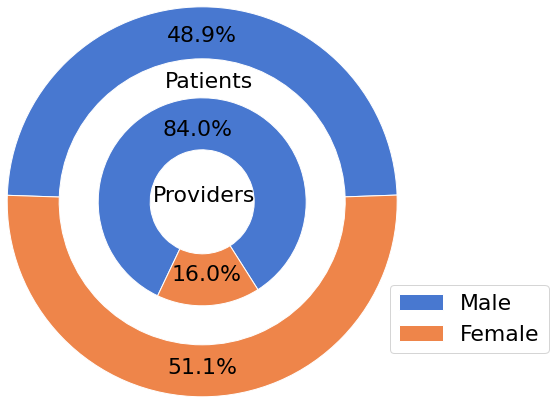

In [254]:


plt.rcParams.update({'font.size': 22})
# build the labels and counts to display
source_labels = ["Male","Female"]
source_counts = [201244,210138]

source_counts2= [455588,87095]
fig,ax=plt.subplots(figsize=(6,6))
fig.tight_layout()
fig.subplots_adjust(top=1.85)
fig.subplots_adjust(top=0.92)
#fig.suptitle("Procedures Performed", fontsize=FONT_LARGE)


cmap = plt.get_cmap("tab20c")
c2map = sns.color_palette("muted")

outer_colors = cmap([1,5])
inner_colors = cmap([2,6])

outer_colors = c2map[0:2]
inner_colors = outer_colors

w,t,at= ax.pie(x=source_counts,
#               labels=source_labels,
               autopct='%1.1f%%',
#               labeldistance=1.1, 
               radius=1.5, 
               colors=outer_colors, 
               pctdistance=.85,
               startangle=1.98,
      wedgeprops=dict(width=.4,edgecolor='w'))
ax.pie(x=source_counts2,
       autopct='%1.1f%%',
       labeldistance=1.1, 
       radius=.8,
       colors=inner_colors, 
       startangle=-57.6,
       pctdistance=.7,
      wedgeprops=dict(width=.4,edgecolor='w'))
ax.text(.348,.5,'Providers',transform=ax.transAxes)
ax.text(.385,.85,'Patients',transform=ax.transAxes)
#ax.text(.41,.13,'Patients',transform=ax.transAxes)
ax.legend(w,["Male","Female"],loc="lower right", bbox_to_anchor=(1.1,0,0.5,1))
#ircle2=plt.Circle( (0,0), 0.80, color='white')
#circle2=ax.pie(x=source_counts,labels=source_labels,autopct='%1.1f%%',labeldistance=1.1)
#p=plt.gcf()
#p.gca().add_artist(circle2)
plt.savefig('PIE_Gender_sm.png',bbox_inches='tight',pad_inches=.1, transparent=False)
plt.show()

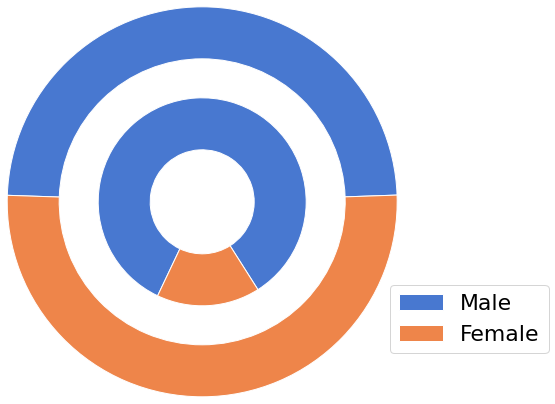

In [274]:


plt.rcParams.update({'font.size': 22})
# build the labels and counts to display
source_labels = ["Male","Female"]
source_counts = [201244,210138]

source_counts2= [455588,87095]
fig,ax=plt.subplots(figsize=(6,6))
fig.tight_layout()
fig.subplots_adjust(top=1.85)
fig.subplots_adjust(top=0.92)
#fig.suptitle("Procedures Performed", fontsize=FONT_LARGE)


cmap = plt.get_cmap("tab20c")
c2map = sns.color_palette("muted")

outer_colors = cmap([1,5])
inner_colors = cmap([2,6])

outer_colors = c2map[0:2]
inner_colors = outer_colors

w,t= ax.pie(x=source_counts,
#               labels=source_labels,
#               autopct='%1.1f%%',
#               labeldistance=1.1, 
               radius=1.5, 
               colors=outer_colors, 
               pctdistance=.85,
               startangle=1.98,
      wedgeprops=dict(width=.4,edgecolor='w'))
ax.pie(x=source_counts2,
#       autopct='%1.1f%%',
#       labeldistance=1.1, 
       radius=.8,
       colors=inner_colors, 
       startangle=-57.6,
       pctdistance=.7,
      wedgeprops=dict(width=.4,edgecolor='w'))
#ax.text(.348,.5,'Providers',transform=ax.transAxes)
#ax.text(.385,.85,'Patients',transform=ax.transAxes)
#ax.text(.41,.13,'Patients',transform=ax.transAxes)
ax.legend(w,["Male","Female"],loc="lower right", bbox_to_anchor=(1.1,0,0.5,1))
#ircle2=plt.Circle( (0,0), 0.80, color='white')
#circle2=ax.pie(x=source_counts,labels=source_labels,autopct='%1.1f%%',labeldistance=1.1)
#p=plt.gcf()
#p.gca().add_artist(circle2)
plt.savefig('PIE_Gender_sm_ro.png',bbox_inches='tight',pad_inches=.1, transparent=False)
plt.show()

***
***
## Now lets work with only "Primary" records to remove any skewing due to multiple providers per patient.

In [54]:
# Start by selecting only the records in df_cum that have a Primary Care Provider

df_primary=df_cum[df_cum['CrewMemberRoles'].str.find('Primary')!=(-1)]
num_Prim=len(df_primary)
num_Pat=len(df_primary['PatientId'].unique())
print("There are {} records with a Primary provider specified.".format(num_Prim))
print("There are {} unique patients in this set.".format(num_Pat))
print("That means there are {} records that provide conflicting or duplicate information.".format(num_Prim-num_Pat))
print("That's only {:.2f}% of the total records.".format((num_Prim-num_Pat)/num_Prim*100))

There are 246920 records with a Primary provider specified.
There are 246828 unique patients in this set.
That means there are 92 records that provide conflicting or duplicate information.
That's only 0.04% of the total records.


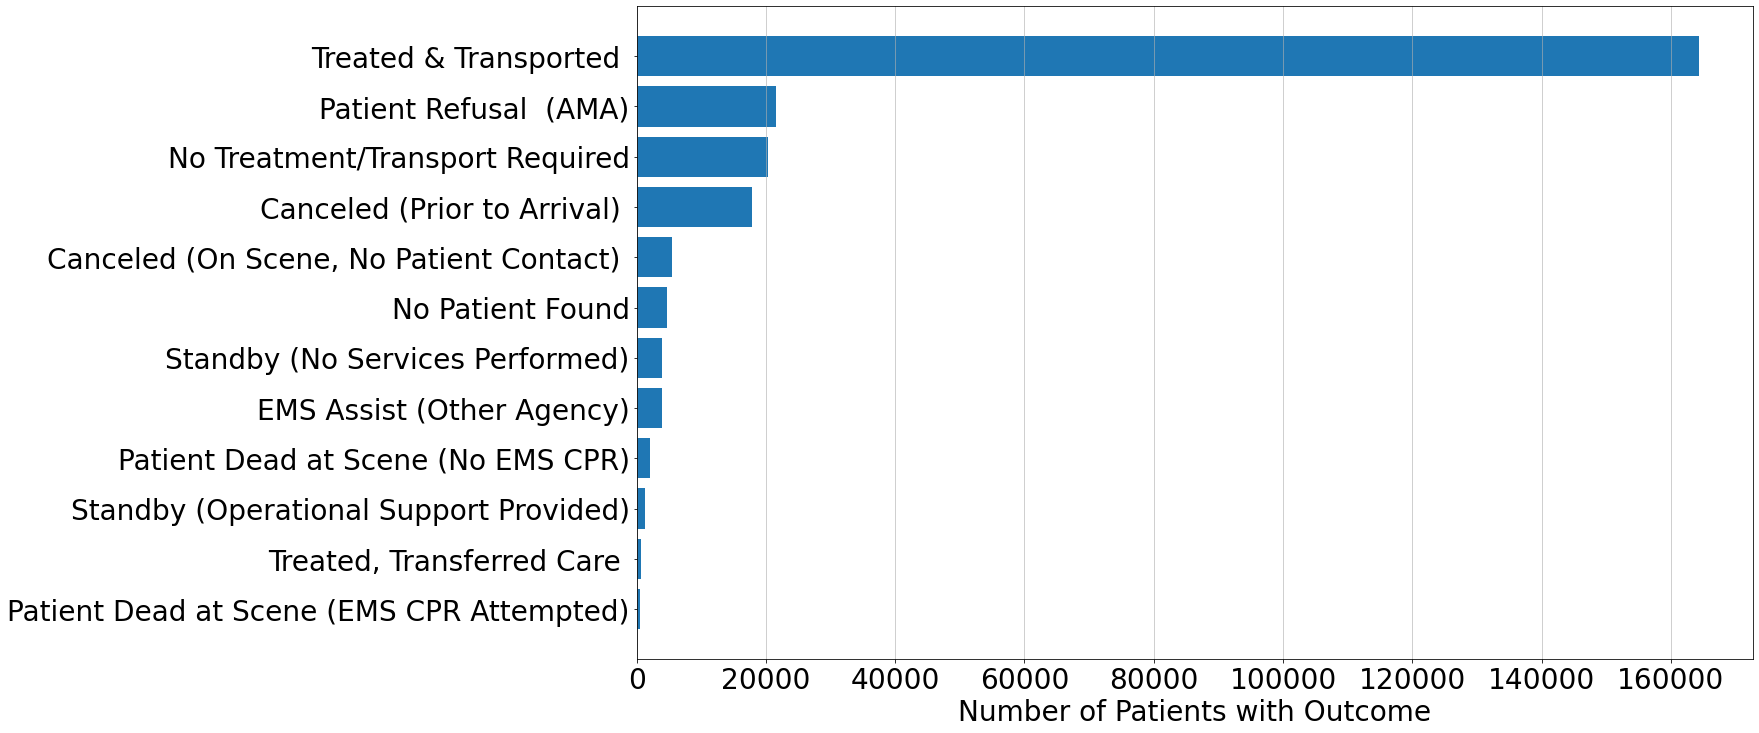

In [273]:
fig=plt.figure(figsize=(20,12))
plt.rcParams.update({'font.size': 28})
value_counts=df_primary['PatientOutcome'].value_counts()
df_Outcomes2=pd.DataFrame(value_counts)
df_Outcomes2.reset_index(inplace=True)
df_Outcomes2.columns=["Outcome","Count"]
df_Outcomes2=df_Outcomes2.sort_values('Count')

#Bar chart
ax1=plt.subplot()
ax1.barh(df_Outcomes2['Outcome'],width=df_Outcomes2['Count'])
ax1.set_xlabel('Number of Patients with Outcome')
ax1.grid(axis='x', alpha=.75)

plt.savefig('Outcome.png',bbox_inches='tight',pad_inches=.1, transparent=False)

#fig.suptitle('Outcome Distribution')
plt.show()

## Summary
### Question: Is there a relationship between Category of EMS call outcome and the provider tenure?
__Answer: There seems to be NO significant indicators of a relationship or anomaly associated with tenure and the EMS Call Outcome.__

### Conclusions / Observations

1. The distribution of Patient Outcomes is nominally similar across all tenures (by year).
2. The distribution of tenures (by year) is nominally similar across all patient outcomes.
3. These distributions are consistent with the distributions of their underlying factors.
4. There appears to be some minor anomalies in the >30 years crowd that may need further investigation but he numbers are so small it is likely insignificant
5. There are a number of inconsistent records in the orginal data set that indicate a provider start date that is after the dispatch time/date.  "Time Travelers"
6. While the alternate calculation of tenure (call count) showed some interesting findings for certain outcomes the lack of a baseline of data to establish initial tenure (everyone starts at zero in this dataset) makes this method less useful for further analysis.
7. There appears to be no clear evidence of systemic "burnout" or "compasion fatigue". 

### Recommendations / Next Steps

1. Clearly define tenure at the beginning of the analysis.
2. Improve the collection of the key factors in calculating tenure (e.g. personnel start date).
3. Record "author" as a field to determine who made the patient outcome determination and who was responsible for creating the ECPR.
4. Provide additional training or refresher information to staff on data entry norms. (One line per provider with multi-select for roles instead of one line per role)
5. Investigate some other ways to determine tenure (call count, years experience, etc)



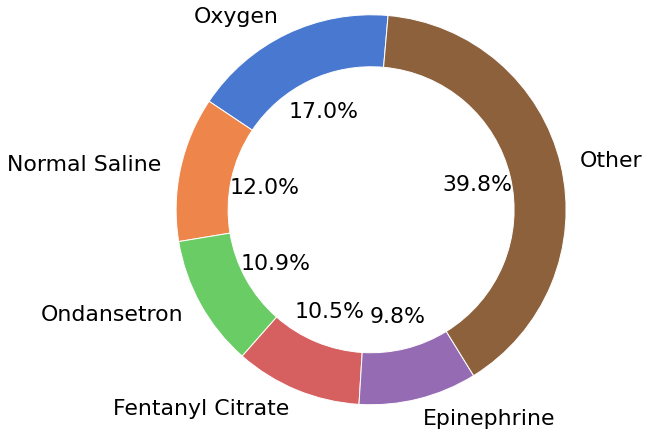

In [268]:


plt.rcParams.update({'font.size': 22})
# build the labels and counts to display
source_labels = ["Oxygen","Normal Saline", "Ondansetron", "Fentanyl Citrate", "Epinephrine", "Other"]
source_counts = [17,12,10.9,10.5,9.8,39.8]

#source_counts2= [455588,87095]
fig,ax=plt.subplots(figsize=(6,6))
fig.tight_layout()
fig.subplots_adjust(top=1.85)
fig.subplots_adjust(top=0.92)
#fig.suptitle("Procedures Performed", fontsize=FONT_LARGE)


cmap = plt.get_cmap("tab20c")
c2map = sns.color_palette("muted")

outer_colors = cmap([1,5])
inner_colors = cmap([2,6])

outer_colors = c2map[0:6]
inner_colors = outer_colors

w,t,at= ax.pie(x=source_counts,
               labels=source_labels,
               autopct='%1.1f%%',
#               labeldistance=1.1, 
               radius=1.5, 
               colors=outer_colors, 
               pctdistance=.56,
               startangle=85,
      wedgeprops=dict(width=.4,edgecolor='w'))

plt.savefig('PIE_Meds.png',bbox_inches='tight',pad_inches=.1, transparent=False)
plt.show()

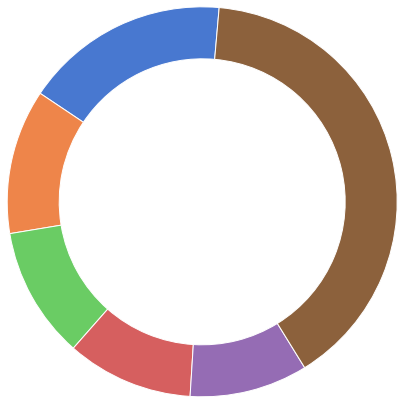

In [270]:


plt.rcParams.update({'font.size': 22})
# build the labels and counts to display
source_labels = ["Oxygen","Normal Saline", "Ondansetron", "Fentanyl Citrate", "Epinephrine", "Other"]
source_counts = [17,12,10.9,10.5,9.8,39.8]

#source_counts2= [455588,87095]
fig,ax=plt.subplots(figsize=(6,6))
fig.tight_layout()
fig.subplots_adjust(top=1.85)
fig.subplots_adjust(top=0.92)
#fig.suptitle("Procedures Performed", fontsize=FONT_LARGE)


cmap = plt.get_cmap("tab20c")
c2map = sns.color_palette("muted")

outer_colors = cmap([1,5])
inner_colors = cmap([2,6])

outer_colors = c2map[0:6]
inner_colors = outer_colors

w,t= ax.pie(x=source_counts,
#              labels=source_labels,
#               autopct='%1.1f%%',
#               labeldistance=1.1, 
               radius=1.5, 
               colors=outer_colors, 
               pctdistance=.56,
               startangle=85,
      wedgeprops=dict(width=.4,edgecolor='w'))

plt.savefig('PIE_Meds_ro.png',bbox_inches='tight',pad_inches=.1, transparent=False)
plt.show()

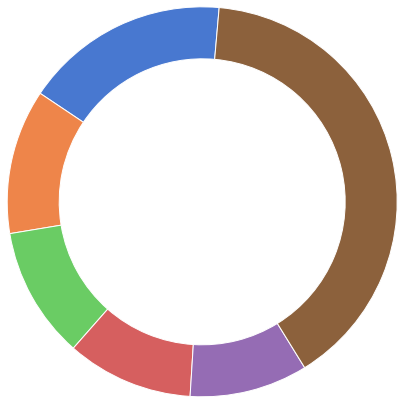

In [270]:


plt.rcParams.update({'font.size': 22})
# build the labels and counts to display
source_labels = ["Oxygen","Normal Saline", "Ondansetron", "Fentanyl Citrate", "Epinephrine", "Other"]
source_counts = [17,12,10.9,10.5,9.8,39.8]

#source_counts2= [455588,87095]
fig,ax=plt.subplots(figsize=(6,6))
fig.tight_layout()
fig.subplots_adjust(top=1.85)
fig.subplots_adjust(top=0.92)
#fig.suptitle("Procedures Performed", fontsize=FONT_LARGE)


cmap = plt.get_cmap("tab20c")
c2map = sns.color_palette("muted")

outer_colors = cmap([1,5])
inner_colors = cmap([2,6])

outer_colors = c2map[0:6]
inner_colors = outer_colors

w,t= ax.pie(x=source_counts,
#              labels=source_labels,
#               autopct='%1.1f%%',
#               labeldistance=1.1, 
               radius=1.5, 
               colors=outer_colors, 
               pctdistance=.56,
               startangle=85,
      wedgeprops=dict(width=.4,edgecolor='w'))

plt.savefig('PIE_Meds_ro.png',bbox_inches='tight',pad_inches=.1, transparent=False)
plt.show()

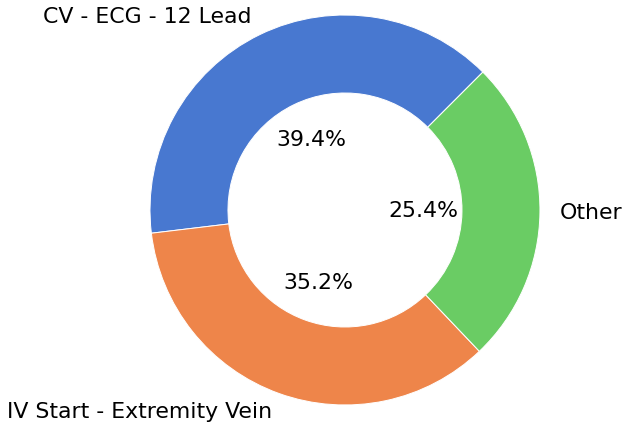

In [275]:
c2map = sns.color_palette("muted")

outer_colors = c2map[0:3]
inner_colors = outer_colors

plt.rcParams.update({'font.size': 22})
# build the labels and counts to display
#source_labels = dfProcGrpPie2.Procedure_Description
source_labels = ["CV - ECG - 12 Lead","IV Start - Extremity Vein","Other"]
source_counts = [39.4,35.2,25.4]
fig,ax=plt.subplots(figsize=(6,6))
fig.tight_layout()
fig.subplots_adjust(top=1.85)
fig.subplots_adjust(top=0.92)
#fig.suptitle("Procedures Performed", fontsize=FONT_LARGE)

ax.pie(x=source_counts,
       labels=source_labels,
       autopct='%1.1f%%',
       labeldistance=1.1,
       radius=1.5,
       colors=inner_colors, 
       startangle=45,
#       pctdistance=.8,
       pctdistance=.4,
      wedgeprops=dict(width=.6,edgecolor='w'))
#circle2=plt.Circle( (0,0), 0.80, color='white')
#p=plt.gcf()
#p.gca().add_artist(circle2)
plt.savefig('PIE_procedures.png',bbox_inches='tight',pad_inches=.1, transparent=False)
plt.show()


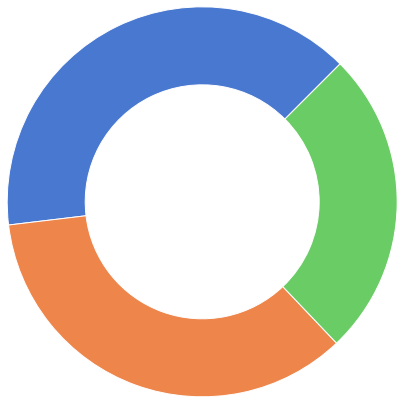

In [276]:
c2map = sns.color_palette("muted")

outer_colors = c2map[0:3]
inner_colors = outer_colors

plt.rcParams.update({'font.size': 22})
# build the labels and counts to display
#source_labels = dfProcGrpPie2.Procedure_Description
source_labels = ["CV - ECG - 12 Lead","IV Start - Extremity Vein","Other"]
source_counts = [39.4,35.2,25.4]
fig,ax=plt.subplots(figsize=(6,6))
fig.tight_layout()
fig.subplots_adjust(top=1.85)
fig.subplots_adjust(top=0.92)
#fig.suptitle("Procedures Performed", fontsize=FONT_LARGE)

ax.pie(x=source_counts,
#       labels=source_labels,
#       autopct='%1.1f%%',
#       labeldistance=1.1,
       radius=1.5,
       colors=inner_colors, 
       startangle=45,
#       pctdistance=.8,
       pctdistance=.4,
      wedgeprops=dict(width=.6,edgecolor='w'))
#circle2=plt.Circle( (0,0), 0.80, color='white')
#p=plt.gcf()
#p.gca().add_artist(circle2)
plt.savefig('PIE_procedures_ro.png',bbox_inches='tight',pad_inches=.1, transparent=False)
plt.show()
